In [1]:
%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
cd drive/MyDrive/EE\ 641/Project

/content/drive/MyDrive/EE 641/Project


In [4]:
from models import *
import math
from torchvision.utils import save_image
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import os

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [5]:
device = torch.device("cuda")

In [6]:
student_model = RIFE_Model()
student_model.load_model('ckpt')
student_model.flownet.to(device)

IFNet(
  (block0): IFBlock(
    (conv0): Sequential(
      (0): Sequential(
        (0): Conv2d(6, 120, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): PReLU(num_parameters=120)
      )
      (1): Sequential(
        (0): Conv2d(120, 240, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): PReLU(num_parameters=240)
      )
    )
    (convblock): Sequential(
      (0): Sequential(
        (0): Conv2d(240, 240, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): PReLU(num_parameters=240)
      )
      (1): Sequential(
        (0): Conv2d(240, 240, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): PReLU(num_parameters=240)
      )
      (2): Sequential(
        (0): Conv2d(240, 240, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): PReLU(num_parameters=240)
      )
      (3): Sequential(
        (0): Conv2d(240, 240, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): PReLU(num_parameters=240)
      )
      (4

In [6]:
teacher_model = EMA_VFI_Model()
teacher_model.load_model('ours')
teacher_model.eval()
teacher_model.net.to(device)

MultiScaleFlow(
  (feature_bone): MotionFormer(
    (block1): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): PReLU(num_parameters=32)
        (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): PReLU(num_parameters=32)
      )
    )
    (patch_embed2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): PReLU(num_parameters=64)
    )
    (block2): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): PReLU(num_parameters=64)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): PReLU(num_parameters=64)
      )
    )
    (patch_embed3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): PReLU(num_parameters=128)
    )
    (block3): ConvBlock(
      (conv): Sequential(


# Flow Visualization

In [7]:
def hsv_to_rgb(hsv):
    h, s, v = hsv[:, 0], hsv[:, 1], hsv[:, 2]
    i = torch.floor(h * 6)
    f = h * 6 - i
    p = v * (1 - s)
    q = v * (1 - f * s)
    t = v * (1 - (1 - f) * s)
    i = i.long() % 6
    rgb = torch.zeros_like(hsv)
    mask0 = (i == 0); rgb[mask0, 0], rgb[mask0, 1], rgb[mask0, 2] = v[mask0], t[mask0], p[mask0]
    mask1 = (i == 1); rgb[mask1, 0], rgb[mask1, 1], rgb[mask1, 2] = q[mask1], v[mask1], p[mask1]
    mask2 = (i == 2); rgb[mask2, 0], rgb[mask2, 1], rgb[mask2, 2] = p[mask2], v[mask2], t[mask2]
    mask3 = (i == 3); rgb[mask3, 0], rgb[mask3, 1], rgb[mask3, 2] = p[mask3], q[mask3], v[mask3]
    mask4 = (i == 4); rgb[mask4, 0], rgb[mask4, 1], rgb[mask4, 2] = t[mask4], p[mask4], v[mask4]
    mask5 = (i == 5); rgb[mask5, 0], rgb[mask5, 1], rgb[mask5, 2] = v[mask5], p[mask5], q[mask5]
    return rgb.clamp(0, 1)


def visualize_flow(flow):
    with torch.no_grad():
        if flow.dim() == 3:
            flow = flow.unsqueeze(0)
        assert flow.dim() == 4 and flow.shape[1] == 2, "Input flow must have shape (B, 2, H, W) or (2, H, W)"
        B, _, H, W = flow.shape
        u = flow[:, 0, :, :] # dx
        v = flow[:, 1, :, :] # dy
        mag = torch.sqrt(u**2 + v**2)
        ang = torch.atan2(v, u)
        h = (ang + math.pi) / (2 * math.pi)
        h = h.clamp(0, 1)
        mag_max = torch.amax(mag, dim=(1, 2), keepdim=True)
        val = mag / (mag_max + 1e-6)
        val = val.clamp(0, 1)
        s = torch.ones_like(h)
        # Stack H, S, V channels
        hsv = torch.stack([h, s, val], dim=1)
        # Convert HSV to RGB
        rgb = hsv_to_rgb(hsv)
        if B == 1 and flow.dim() == 3:
            rgb = rgb.squeeze(0)
    return rgb

In [8]:
path = "TEST08_079_f0321"
# path = "TEST02_045_f0465"

I0 = cv2.imread(path + '/im4.png')
I2 = cv2.imread(path + '/im5.png')
I0 = (torch.tensor(I0.transpose(2, 0, 1)).to(device) / 255.).unsqueeze(0)
I2 = (torch.tensor(I2.transpose(2, 0, 1)).to(device) / 255.).unsqueeze(0)

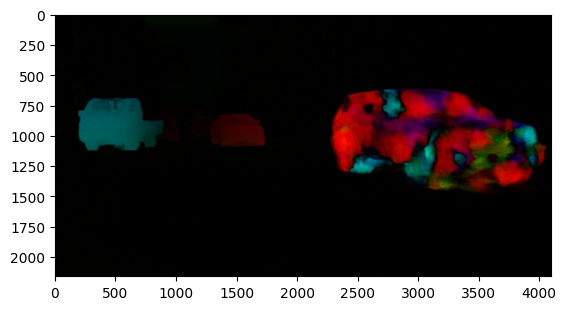

In [11]:
rife_pred, rife_flow = student_model.inference(I0, I2)
rife_flow_vis = visualize_flow(rife_flow[:, :2, :, :])
plt.imshow(rife_flow_vis.cpu().detach()[0].permute(1, 2, 0).numpy())

In [ ]:
rife_flow.shape

torch.Size([1, 4, 2160, 4096])

In [9]:
# I0 = cv2.imread(path + '/im4.png')
# I2 = cv2.imread(path + '/im5.png')
# I0 = (torch.tensor(I0.transpose(2, 0, 1)).to(device) / 255.).unsqueeze(0)
# I2 = (torch.tensor(I2.transpose(2, 0, 1)).to(device) / 255.).unsqueeze(0)
ema_pred, ema_flow = teacher_model.inference_with_flow(I0, I2)
ema_flow_vis = visualize_flow(ema_flow[:, :2, :, :])

# ema_flow_vis = visualize_flow(ema_flow[:, 2:, :, :])

In [ ]:
ema_flow.shape

torch.Size([1, 4, 2160, 4096])

In [ ]:
ema_flow_vis = visualize_flow(ema_flow[:, 2:, :, :])

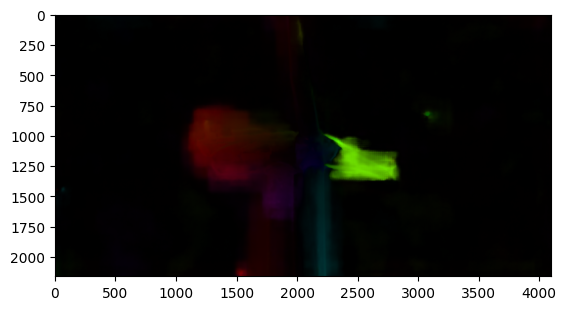

In [ ]:
plt.imshow(ema_flow_vis.cpu().detach()[0].permute(1, 2, 0).numpy())

# Inerpolated Results

In [8]:
distilled_model = RIFE_Model()
distilled_model.flownet.load_state_dict(torch.load('newKDckpt/10_1381.pkl'))

<All keys matched successfully>

In [9]:
path = "TEST08_079_f0321"
# path = "TEST02_045_f0465"
# path = "TEST01_003_f0433"

# I0 = cv2.imread(path + '/0904.png')
# I2 = cv2.imread(path + '/0936.png')
I0 = cv2.imread(path + '/im4.png')
I2 = cv2.imread(path + '/im5.png')
I0 = (torch.tensor(I0.transpose(2, 0, 1)).to(device) / 255.).unsqueeze(0)
I2 = (torch.tensor(I2.transpose(2, 0, 1)).to(device) / 255.).unsqueeze(0)


pred, flow = distilled_model.inference(I0, I2)

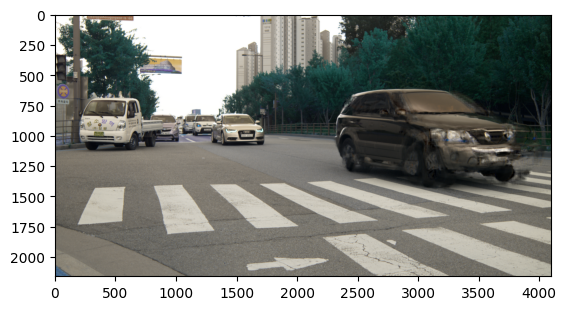

In [10]:
plt.imshow(pred.detach().cpu()[0].permute(1, 2, 0).numpy())

In [10]:
path = "TEST08_079_f0321"
# path = "TEST02_045_f0465"
# path = "TEST01_003_f0433"

# I0 = cv2.imread(path + '/0904.png')
# I2 = cv2.imread(path + '/0936.png')
I0 = cv2.imread(path + '/im4.png')
I2 = cv2.imread(path + '/im5.png')
I0 = (torch.tensor(I0.transpose(2, 0, 1)).to(device) / 255.).unsqueeze(0)
I2 = (torch.tensor(I2.transpose(2, 0, 1)).to(device) / 255.).unsqueeze(0)


pred= distilled_model1.inference(I0, I2)

## Output-based Distilled

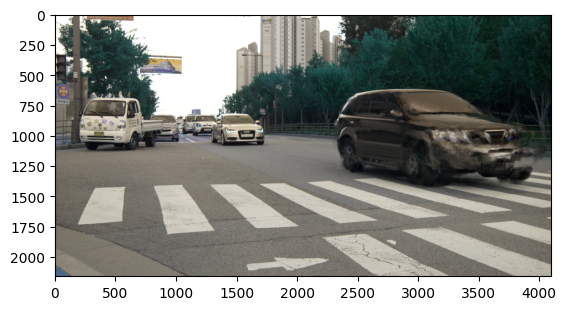

In [11]:
plt.imshow(pred.detach().cpu()[0].permute(1, 2, 0).numpy())

## Flow-based Distilled

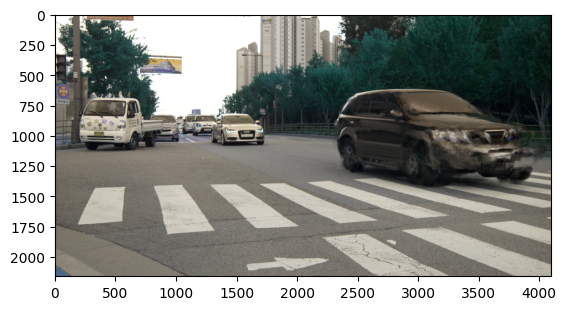

In [11]:
plt.imshow(pred.detach().cpu()[0].permute(1, 2, 0).numpy())

In [12]:
save_image(pred, 'distilled1_pred.png')

## Student

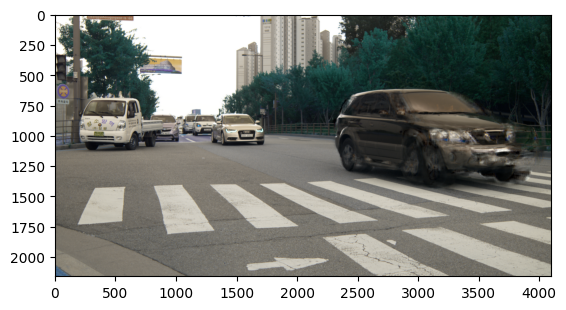

In [12]:
plt.imshow(rife_pred.detach().cpu()[0].permute(1, 2, 0).numpy())

In [13]:
save_image(rife_pred, 'student_pred.png')

## Teacher

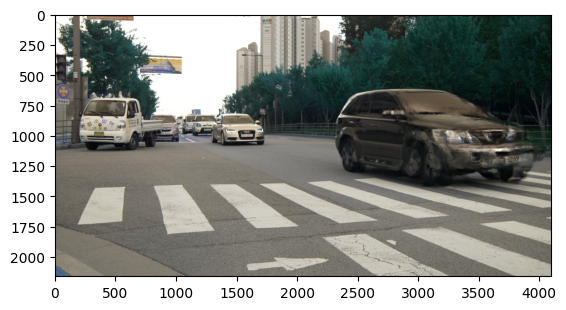

In [10]:
plt.imshow(ema_pred.detach().cpu()[0].permute(1, 2, 0).numpy())

In [11]:
save_image(ema_pred, 'teacher_pred.png')